In [1]:
import yaml
import numpy as np
import learners
import dataloaders
from torch.utils.data import DataLoader
import pickle
import matplotlib.pyplot as plt
import json

In [2]:
def softmax(data):
    e = np.exp(data)
    return e / np.sum(e, axis=1, keepdims=True)

def read_fine_label(path='fine_label_map.json'):
    loadded_data = json.load(open(path))
    loadded_data = {int(k):v for k,v in loadded_data.items()}
    return loadded_data

In [3]:
with open('metric_table.pkl', 'rb') as f:
    results = pickle.load(f)

fine_label = read_fine_label()

for current_task_id in results:
    for target_task_id in results[current_task_id]:
        data = results[current_task_id][target_task_id]
        acc = data[0]
        true = data[1]
        pred = data[2]
        logits = data[3]
        prob = softmax(logits)
        results[current_task_id][target_task_id] = (acc, true, pred, prob)


In [4]:
def obtain_results(check_task_id, results, fine_label):
    x = []
    ys = []

    x = [index for index in range(check_task_id, len(results))]

    for target_task_id in range(check_task_id, len(results)):
        data = results[target_task_id][check_task_id]   # target_task_id에서 학습된 모델에 대한 check_task_id에서의 결과
        acc = data[0]
        true = data[1]
        pred = data[2]
        prob = data[3]
        
        incurrect = {index: 0 for index in np.unique(true)}
        string_label = [fine_label[index] for index in np.unique(true)]
        for i in range(len(true)):
            if true[i] != pred[i]:
                incurrect[true[i]] += 1
        y = [incurrect[index] for index in np.unique(true)]
        ys.append(y)
        
    x = np.array(x)
    ys = np.array(ys)
    ys = np.transpose(ys)
    return x, ys, string_label

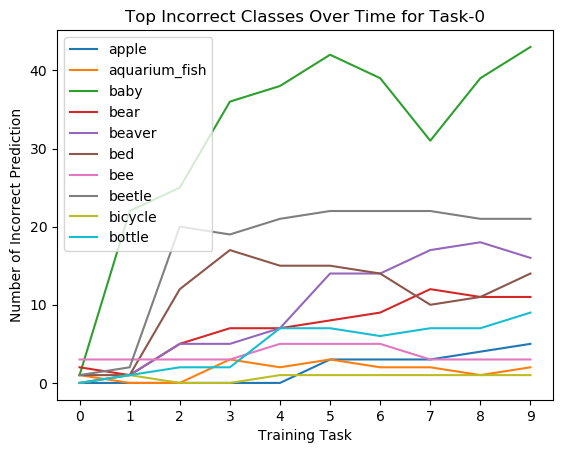

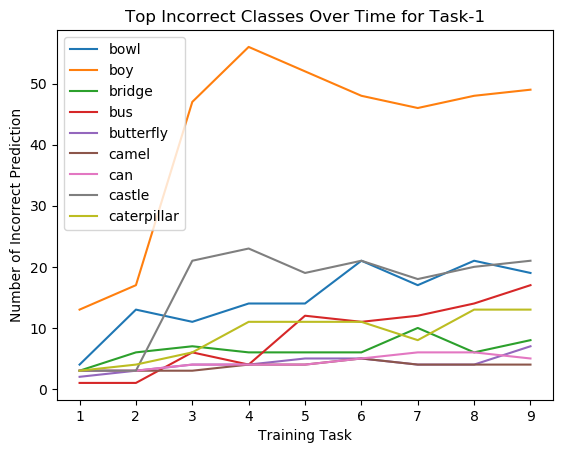

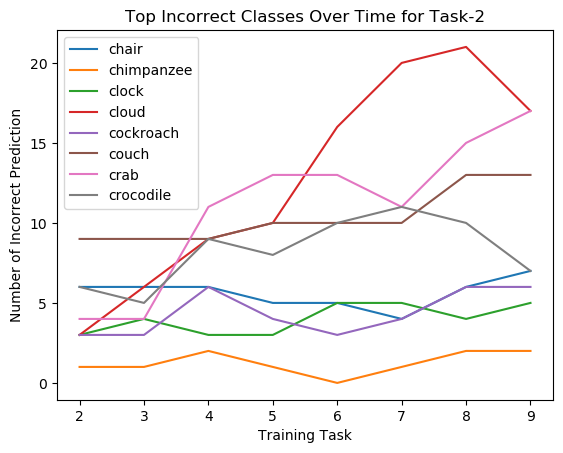

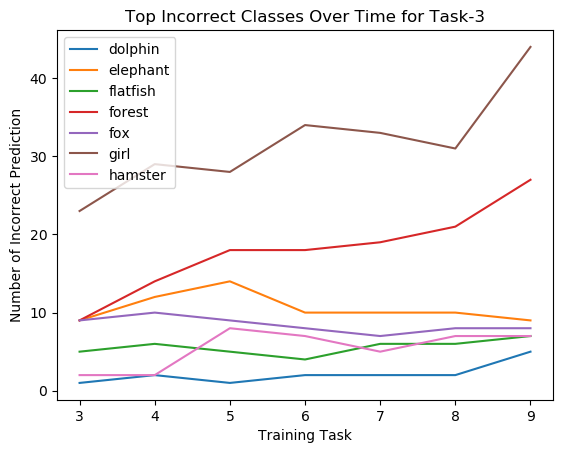

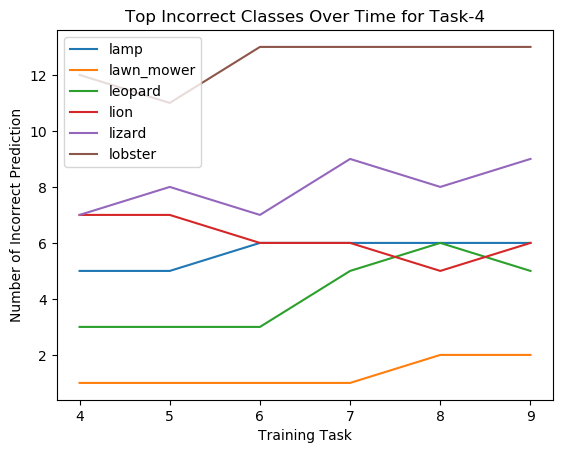

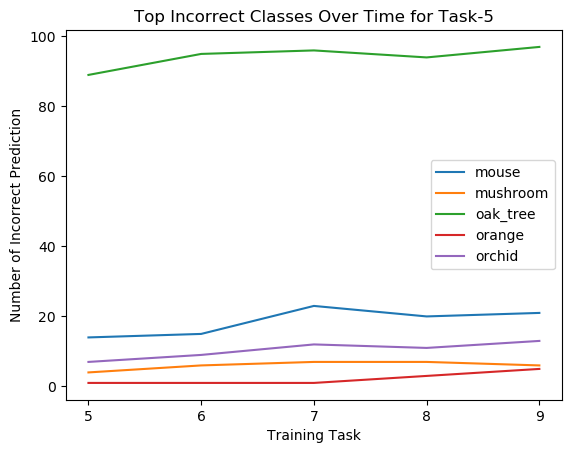

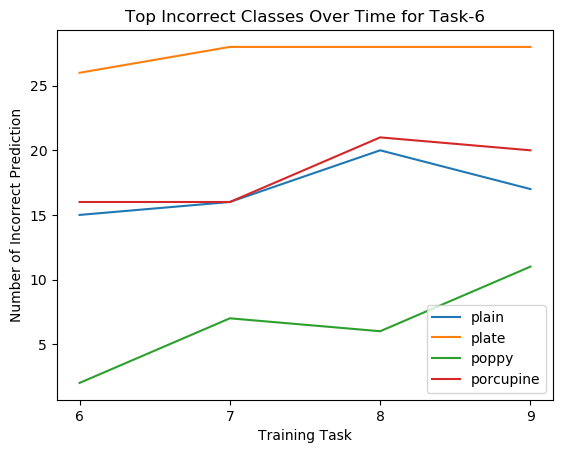

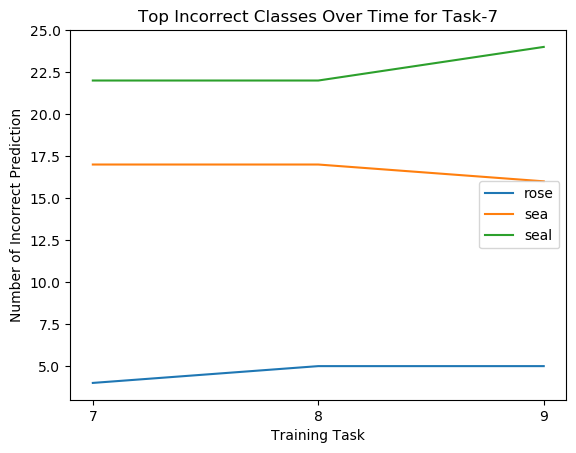

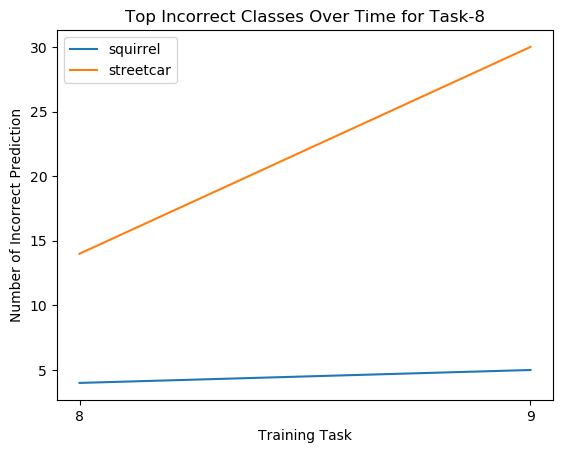

In [8]:
import os

os.makedirs('figures', exist_ok=True)

for check_task_id in range(0, len(results) - 1):
    x, ys, string_label = obtain_results(check_task_id, results, fine_label)
    plt.figure()
    plt.xticks(x)
    for i in range(len(x)):
        plt.plot(x, ys[i], label=f'{string_label[i]}')
    plt.xlabel('Training Task')
    plt.ylabel('Number of Incorrect Prediction')
    plt.title(f'Top Incorrect Classes Over Time for Task-{check_task_id}')
    plt.legend()
    plt.savefig(f'figures/task_{check_task_id}.png')